I this notebook I use partial district information of the election 2021 to predict the full election results. I use the full results of 2016 to improve the results. 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

First I load the results of the two elections. In both the votes have two votes, the second vote is much more important and thus I concentrate on it. 

In [7]:
elec16_vote1=pd.read_excel('DL_BE_EE_WB_AH2016.xlsx',sheet_name='Erststimme')
print(elec16_vote1.columns)
elec16_vote2=pd.read_excel('DL_BE_EE_WB_AH2016.xlsx',sheet_name='Zweitstimme')
print(elec16_vote2.columns)
elec21_vote1=pd.read_excel('DL_BE_AGHBVV2021.xlsx',sheet_name='AGH_W1')
elec21_vote2=pd.read_excel('DL_BE_AGHBVV2021.xlsx',sheet_name='AGH_W2')
print(elec21_vote1.columns)
print(elec21_vote2.columns)
print(elec16_vote2.shape)
print(elec21_vote2.shape)

Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'Abgeordneten-\nhauswahlkreis',
       'Bundestags-\nwahlkreis', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt', 'Wahlberechtigte A1', 'Wahlberechtigte A2',
       'Wahlberechtigte A3', 'Wähler', 'Wähler B1', 'Ungültige Stimmen',
       'Gültige Stimmen', 'SPD', 'CDU', 'GRÜNE', 'DIE LINKE', 'PIRATEN', 'NPD',
       'FDP', 'Tierschutzpartei', 'pro Deutschland', 'Die PARTEI', 'BIG',
       'DKP', 'ödp', 'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther',
       'MENSCHLICHE WELT', 'MIETERPARTEI', 'Gesundheits-\nforschung', 'EB 1',
       'EB 2', 'EB 3', 'EB 4', 'EB 5', 'EB 6', 'EB 7', 'EB 8', 'EB 9', 'EB 10',
       'EB 11', 'EB 12', 'EB 13', 'EB 14', 'EB 15', 'EB 16', 'EB 17', 'EB 18'],
      dtype='object')
Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'Abgeord

I also look on the last two federal elections in Berlin because there likely more similar to each other because the state election in 2021 was at the same time as the federal election then and is such influenced by it. At least there was higher turnut because that combination.

In [6]:
bw17_vote1=pd.read_excel('DL_BE_EE_WB_BU2017.xlsx',sheet_name='BE_W1')
bw17_vote2=pd.read_excel('DL_BE_EE_WB_BU2017.xlsx',sheet_name='BE_W2')
print(bw17_vote1.columns)
print(bw17_vote1.shape)
print(bw17_vote2.columns)
bw21_vote1=pd.read_excel('DL_BE_BU2021.xlsx',sheet_name='BE_W1')
bw21_vote2=pd.read_excel('DL_BE_BU2021.xlsx',sheet_name='BE_W2')
print(bw21_vote1.columns)
print(bw21_vote1.shape)
print(bw21_vote2.columns)

Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'Abgeordneten-\nhauswahlkreis',
       'Bundestags-\nwahlkreis', 'OstWest', 'Wahlberechtigte insgesamt',
       'Wahlberechtigte A1', 'Wahlberechtigte A2', 'Wahlberechtigte A3',
       'Wähler', 'Wähler B1', 'Ungültige Stimmen', 'Gültige Stimmen', 'CDU',
       'SPD', 'DIE LINKE', 'GRÜNE', 'AfD', 'PIRATEN', 'FDP', 'Die PARTEI',
       'FREIE WÄHLER', 'ÖDP', 'BüSo', 'MLPD', 'SGP', 'B*', 'BGE', 'DiB', 'DKP',
       'DM', 'Die Grauen', 'du.', 'MENSCHLICHE WELT',
       'Gesundheits-\nforschung', 'Tierschutz-\npartei', 'V-Partei³',
       'DIE FRAUEN', 'EB Für Dich im Bundestag', 'EB GROG',
       'EB Grundeinkommen-für-alle.org 1', 'EB Grundeinkommen-für-alle.org 2',
       'EB Ideengeber Mensch Natur Technik',
       'EB LIBERAL NACHHALTIG SOZIAL WELTOFFEN',
       'EB Den Menschen verpflichtet, keiner Partei!', 'MIETERPARTEI', 'NPD',
       'EB', 'EB Parteifrei. Für die Menschen',
      

In both cases the newer election have more election districts. That measn directly matching does not work. The elections ate the same day have the same number of districts as to be expected. However, they are likely more similar than two election at different days. There I compare now also the state election in 2016 and the federal election in 2021. 

First I merge the second vote of the two state elections using keys (adresse). 

In [8]:
combined=elec16_vote2.merge(elec21_vote2,how='left',left_on='Adresse',right_on='Adresse')

In [9]:
print(combined.shape)
print(elec21_vote2.shape)
print(elec16_vote2.shape)
print(combined.columns)

(2432, 95)
(3764, 53)
(2432, 43)
Index(['Adresse', 'Stimmart_x', 'Bezirksnummer_x', 'Bezirksname_x',
       'Wahlbezirk_x', 'Wahlbezirksart_x', 'Abgeordneten-\nhauswahlkreis_x',
       'Bundestags-\nwahlkreis_x', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt_x', 'Wahlberechtigte A1_x',
       'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x', 'Wähler', 'Wähler B1',
       'Ungültige Stimmen_x', 'Gültige Stimmen_x', 'SPD_x', 'CDU_x', 'GRÜNE_x',
       'DIE LINKE_x', 'PIRATEN_x', 'NPD_x', 'FDP_x', 'Tierschutzpartei_x',
       'pro Deutschland', 'Die PARTEI_x', 'BIG', 'DKP_x', 'ödp', 'PSG',
       'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD_x',
       'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther_x', 'MENSCHLICHE WELT_x',
       'MIETERPARTEI_x', 'Gesundheits-\nforschung', 'Stimmart_y',
       'Bezirksnummer_y', 'Bezirksname_y', 'Wahlbezirk_y', 'Wahlbezirksart_y',
       'Briefwahlbezirk', 'Abgeordneten-\nhauswahlkreis_y',
       'Bundestags-\nwahlkreis_y', 'OstWest', 'Wah

The number of rows is clearly different in the two tables. That means there is not always a perfect match which makes predictions more difficult. 

Below I print some prorties of these districts, to understand teh reasons ofr the missmacthes

In [10]:
nulls=combined.Bezirksnummer_y.isnull()
n_null=0
for i in range(combined.shape[0]):
    if nulls[i]==True:
        print(combined.iloc[i,1:18])
        n_null+=1
print(f"number of NULL {n_null}")
print(f"difference in election districts{elec21_vote2.shape[0]-elec16_vote2.shape[0]}") 

Stimmart_x                            Zweitstimme
Bezirksnummer_x                                 5
Bezirksname_x                             Spandau
Wahlbezirk_x                                   5I
Wahlbezirksart_x                  Briefwahlbezirk
Abgeordneten-\nhauswahlkreis_x                  5
Bundestags-\nwahlkreis_x                       78
Berlin\nOstWest                                 W
Wahlberechtigte insgesamt_x                     0
Wahlberechtigte A1_x                            0
Wahlberechtigte A2_x                            0
Wahlberechtigte A3_x                            0
Wähler                                        520
Wähler B1                                     520
Ungültige Stimmen_x                             3
Gültige Stimmen_x                             516
SPD_x                                          89
Name: 946, dtype: object
Stimmart_x                                Zweitstimme
Bezirksnummer_x                                     6
Bezirksname_x    

There about as many nulls as there are more districts. Only 37 seem to have other reasons, thus the main reason is the larger number of districts in 2021. That clearly different number of districts could make predictions more difficult. 

For now the problem is ignored by cleaning the NaN cases.



In [11]:
cleaned=combined.loc[combined.Bezirksnummer_y.isnull()==False]
print(cleaned.shape)

(2395, 95)




As a first trial the percentage differnce is predicted as finction of the percentage.  We are starting with the SPD.

In [12]:
#needs 2 d rarray
tar=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.SPD_x/cleaned['Gültige Stimmen_x']
ser1=cleaned.SPD_y/cleaned['Gültige Stimmen_x']*100
ser2=cleaned.CDU_y/cleaned['Gültige Stimmen_x']*100
feat = pd.concat([ser1,ser2],axis=1)

In [13]:



feat_train,feat_test,tar_train, tar_test= train_test_split(feat,tar,train_size=0.50, shuffle=True, random_state=1)

In [14]:
reg=LinearRegression().fit(feat_train, tar_train)

In [15]:
predli1te=reg.predict(feat_test)
predli1tr=reg.predict(feat_train)

In [16]:
print(f"standard deviation of data (train) {round(np.std(tar_train),4)} %")
print(f"standard deviation of data (test) {round(np.std(tar_test),4)} %")
print(f"standard deviation of train-data (train) {round(np.std(predli1tr-tar_train),4)} %")
print(f"standard deviation of prediction-data (test) {round(np.std(predli1te-tar_test),4)} %")

standard deviation of data (train) 4.9951 %
standard deviation of data (test) 4.8475 %
standard deviation of train-data (train) 4.7516 %
standard deviation of prediction-data (test) 4.5602 %


The prediction is similar good in train and test, but both improve only by a little compared to having no prediction. Does not look good area missmatch or just not enough parameters.

Text(0, 0.5, '% 2021-2016 (prediction-data)')

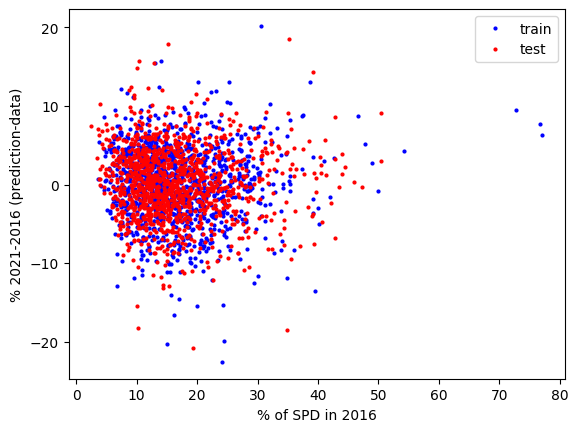

In [17]:
plt.plot(feat_train.iloc[:,0],predli1tr-tar_train,'o',ms=2,color='blue',label='train') 
plt.plot(feat_test.iloc[:,0],predli1te-tar_test,'o',ms=2,color='red',label='test') 
plt.legend(loc="best")
plt.xlabel("% of SPD in 2016")
plt.ylabel("% 2021-2016 (prediction-data)")

In [18]:
regx=XGBRegressor().fit(feat_train, tar_train)

Now I use as alternative XGBregressor.

In [19]:
predli1tex=regx.predict(feat_test)
predli1trx=regx.predict(feat_train)

In [20]:
print(f"standard deviation of test {round(np.std(predli1tex-tar_test),4)} %")
print(f"standard deviation of train {round(np.std(predli1trx-tar_train),4)} %")

standard deviation of test 5.3409 %
standard deviation of train 1.6661 %


There is clear overfitting. 

Now I am adding more columns (parties) to the feature data. 

In [21]:
tar=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.SPD_x/cleaned['Gültige Stimmen_x']
tarc=cleaned.CDU_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.CDU_x/cleaned['Gültige Stimmen_x']
tara=cleaned.AfD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.AfD_x/cleaned['Gültige Stimmen_x']
tarf=cleaned.FDP_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.FDP_x/cleaned['Gültige Stimmen_x']
tarl=cleaned['DIE LINKE_y']/cleaned['Gültige Stimmen_y']*100-100*cleaned['DIE LINKE_x']/cleaned['Gültige Stimmen_x']
targ=cleaned.GRÜNE_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.GRÜNE_x/cleaned['Gültige Stimmen_x']
ser1=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100
ser2=cleaned.CDU_y/cleaned['Gültige Stimmen_y']*100
ser3=cleaned.GRÜNE_y/cleaned['Gültige Stimmen_y']*100
ser4=cleaned.FDP_y/cleaned['Gültige Stimmen_y']*100
ser5=cleaned['DIE LINKE_y']/cleaned['Gültige Stimmen_y']*100
ser6=cleaned.AfD_y/cleaned['Gültige Stimmen_y']*100
#rest not needed follows automatically
ser7=100-ser1-ser2-ser3-ser4-ser5-ser6
print(ser6.mean(),ser7.mean())
feat2 = pd.concat([ser1,ser2,ser3,ser4,ser5,ser6],axis=1)

9.046068894163886 12.847811644332696


In [22]:
feat2_train,feat2_test,tar_train, tar_test,tarc_train, tarc_test,tara_train, tara_test,tarf_train, tarf_test,tarl_train, tarl_test,targ_train, targ_test= train_test_split(feat2,tar,tarc,tara,tarf,tarl,targ,train_size=0.50, shuffle=True, random_state=1)

In [23]:
reg2=LinearRegression().fit(feat2_train, tar_train)

In [24]:
predli1te2=reg2.predict(feat2_test)
predli1tr2=reg2.predict(feat2_train)

No I look again on the metrics.

In [25]:
print(f"standard deviation of data (train) {round(np.std(tar_train),4)} %")
print(f"standard deviation of data (test) {round(np.std(tar_test),4)} %")
print(f"standard deviation of train-data (train) {round(np.std(predli1tr2-tar_train),4)} %")
print(f"standard deviation of prediction-data (test) {round(np.std(predli1te2-tar_test),4)} %")

standard deviation of data (train) 4.9951 %
standard deviation of data (test) 4.8475 %
standard deviation of train-data (train) 3.4425 %
standard deviation of prediction-data (test) 3.4274 %


The metrics improve but only by a tiny bit and are still not really good. 

In [26]:
regx2=XGBRegressor().fit(feat2_train, tar_train)

In [27]:
predli1tex2=regx2.predict(feat2_test)
predli1trx2=regx2.predict(feat2_train)

In [28]:
print(f"standard deviation of test {round(np.std(predli1tex2-tar_test),4)} %")
print(f"standard deviation of train {round(np.std(predli1trx2-tar_train),4)} %")

standard deviation of test 3.572 %
standard deviation of train 0.4314 %


XGB improves more compared to the previous version but is still slightly worse than linear regression. There is still clear overfitting.

Need to check whether it can be the dostrict matching. Or is it difficult party? 

Now CDU

In [29]:
def get_scatter(feature_train,feature_test,target_train,target_test,name):
    reg2c=LinearRegression().fit(feature_train, target_train)
    predli1te2c=reg2c.predict(feature_test)
    predli1tr2c=reg2c.predict(feature_train)
    reg2cx=XGBRegressor().fit(feature_train, target_train)
    predli1te2cx=reg2cx.predict(feature_test)
    predli1tr2cx=reg2cx.predict(feature_train)
    print(name)
    print(f"standard deviation of data (train) {round(np.std(target_train),4)} %")
    print(f"standard deviation of data (test) {round(np.std(target_test),4)} %")
    print(f"standard deviation of train-data (train) {round(np.std(predli1tr2c-target_train),4)} %")
    print(f"standard deviation of prediction-data (test) {round(np.std(predli1te2c-target_test),4)} %")
    print(f"standard deviation of train-data (train) XGB {round(np.std(predli1tr2cx-target_train),4)} %")
    print(f"standard deviation of prediction-data (test) XGB {round(np.std(predli1te2cx-target_test),4)} %")   

In [30]:
get_scatter(feat2_train,feat2_test,tarc_train,tarc_test,"CDU")

CDU
standard deviation of data (train) 4.6854 %
standard deviation of data (test) 4.5053 %
standard deviation of train-data (train) 4.0837 %
standard deviation of prediction-data (test) 3.8706 %
standard deviation of train-data (train) XGB 0.6 %
standard deviation of prediction-data (test) XGB 4.2138 %


In [31]:
get_scatter(feat2_train,feat2_test,targ_train,targ_test,"Gruene")

Gruene
standard deviation of data (train) 5.7667 %
standard deviation of data (test) 5.6388 %
standard deviation of train-data (train) 4.9244 %
standard deviation of prediction-data (test) 5.0526 %
standard deviation of train-data (train) XGB 0.5031 %
standard deviation of prediction-data (test) XGB 5.4996 %


In [32]:
get_scatter(feat2_train,feat2_test,tarl_train,tarl_test,"die Linke")

die Linke
standard deviation of data (train) 4.7148 %
standard deviation of data (test) 4.7748 %
standard deviation of train-data (train) 4.2597 %
standard deviation of prediction-data (test) 4.1862 %
standard deviation of train-data (train) XGB 0.4656 %
standard deviation of prediction-data (test) XGB 4.2473 %


In [33]:
get_scatter(feat2_train,feat2_test,tara_train,tara_test,"AfD")

AfD
standard deviation of data (train) 3.6788 %
standard deviation of data (test) 3.5955 %
standard deviation of train-data (train) 3.4103 %
standard deviation of prediction-data (test) 3.3856 %
standard deviation of train-data (train) XGB 0.4686 %
standard deviation of prediction-data (test) XGB 3.7491 %


In [34]:
get_scatter(feat2_train,feat2_test,tarf_train,tarf_test,"FDP")

FDP
standard deviation of data (train) 2.9 %
standard deviation of data (test) 2.7637 %
standard deviation of train-data (train) 2.3844 %
standard deviation of prediction-data (test) 2.2237 %
standard deviation of train-data (train) XGB 0.2344 %
standard deviation of prediction-data (test) XGB 2.2656 %


All are similar, none is really good. XGB is not so good. On the other hand the real target is the average of them, thus the impact is not so high. 

Shoudl get impact on final important numbers, percentage and seats. 

Now looking into miss matching in matched ones

In [35]:
nulls=combined.Bezirksnummer_y.isnull()
nn_null=0
for i in range(1):
    if nulls[i]==False:
        print(combined.iloc[i,1:18])
        print(combined.iloc[i,53:69])
        print(combined.iloc[i,7])
        print(combined.iloc[i,58])
        print(combined.iloc[i,14])
        print(combined.iloc[i,65])
        print(combined.iloc[i,2])
        print(combined.iloc[i,54])
        nn_null+=1

Stimmart_x                            Zweitstimme
Bezirksnummer_x                                 1
Bezirksname_x                               Mitte
Wahlbezirk_x                                   1A
Wahlbezirksart_x                  Briefwahlbezirk
Abgeordneten-\nhauswahlkreis_x                  1
Bundestags-\nwahlkreis_x                       75
Berlin\nOstWest                                 O
Wahlberechtigte insgesamt_x                     0
Wahlberechtigte A1_x                            0
Wahlberechtigte A2_x                            0
Wahlberechtigte A3_x                            0
Wähler                                       1480
Wähler B1                                    1480
Ungültige Stimmen_x                             4
Gültige Stimmen_x                            1476
SPD_x                                         299
Name: 0, dtype: object
Wahlberechtigte A1_y       0.0
Wahlberechtigte A2_y       0.0
Wahlberechtigte A3_y       0.0
Wählende                1079.0
Wäh

In [36]:
for i in range(combined.shape[1]):
    if nulls[i]==False and (combined.iloc[i,7]!=combined.iloc[i,58] or combined.iloc[i,2]!=combined.iloc[i,54]) :
        print(combined.iloc[i,7])
        print(combined.iloc[i,58])
        nn_null+=1

75
1079.0
75
1094.0
75
1197.0
75
990.0
75
1195.0
75
796.0
75
1122.0
75
1106.0
75
885.0
75
856.0
75
758.0
75
679.0
75
839.0
75
883.0
75
985.0
75
878.0
75
1144.0
75
643.0
75
546.0
75
818.0
75
641.0
75
857.0
75
625.0
75
641.0
75
688.0
75
649.0
75
593.0
75
575.0
75
575.0
75
401.0
75
490.0
75
423.0
75
681.0
75
593.0
75
648.0
75
794.0
75
629.0
75
515.0
75
362.0
75
404.0
75
328.0
75
520.0
75
427.0
75
538.0
75
421.0
75
359.0
75
362.0
75
571.0
75
413.0
75
474.0
75
609.0
75
639.0
75
380.0
75
286.0
75
590.0
75
600.0
75
414.0
75
444.0
75
425.0
75
484.0
75
424.0
75
343.0
75
464.0
75
426.0
75
501.0
75
521.0
75
451.0
75
485.0
75
426.0
75
352.0
75
485.0
75
467.0
75
375.0
75
368.0
75
230.0
75
281.0
75
415.0
75
365.0
75
331.0
75
406.0
75
302.0
75
370.0
75
546.0
75
338.0
75
584.0
75
492.0
75
446.0
75
253.0
75
540.0
75
430.0
75
471.0
75
370.0
75
483.0
75
353.0
75
418.0


All have the same election district, thus a missmatch problem is the earliest one level below. I look now into the voters of matched districts.

Text(0, 0.5, 'eligible Voters 2021/eligible Voters 2016')

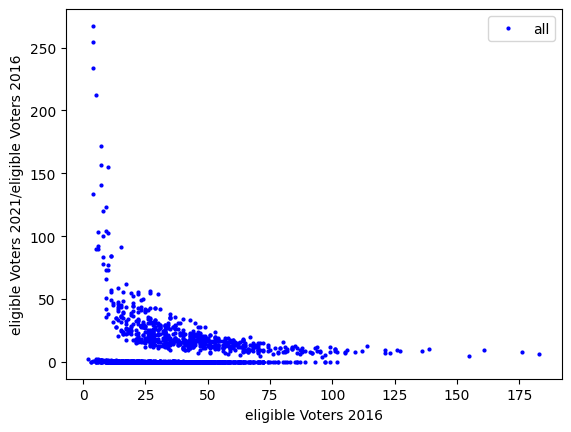

In [37]:
#needs to be redone rwos changed better a differnt column method
plt.plot(cleaned.iloc[:,65],cleaned.iloc[:,14]/cleaned.iloc[:,65],'o',ms=2,color='blue',label='all') 
plt.legend(loc="best")
plt.xlabel("eligible Voters 2016")
plt.ylabel("eligible Voters 2021/eligible Voters 2016")

In [38]:
ser=cleaned.iloc[:,14]/cleaned.iloc[:,65]
print(ser.describe())

count    2395.000000
mean        6.640294
std        17.299102
min         0.000000
25%         0.047619
50%         0.145455
75%         8.280032
max       267.250000
dtype: float64


Clearly not the same districts. Could use larger districts or figure out the border of the district. Could look whether first in one matches better. Likely best to find the id (map) for the districts. 

Now I combined on election district level. It has a two index system. 

In [39]:
#first group by district is double index 
#elec_district16.set_index(['Bezirksnummer', 'Abgeordneten-\nhauswahlkreis'])
elec_district16=elec16_vote2.groupby([elec16_vote2['Bezirksnummer'],elec16_vote2['Abgeordneten-\nhauswahlkreis']]).sum()

/tmp/ipykernel_11291/3230042564.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_district16=elec16_vote2.groupby([elec16_vote2['Bezirksnummer'],elec16_vote2['Abgeordneten-\nhauswahlkreis']]).sum()


In [40]:
elec_district21=elec21_vote2.groupby([elec21_vote2['Bezirksnummer'],elec21_vote2['Abgeordneten-\nhauswahlkreis']]).sum()

/tmp/ipykernel_11291/2124326953.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_district21=elec21_vote2.groupby([elec21_vote2['Bezirksnummer'],elec21_vote2['Abgeordneten-\nhauswahlkreis']]).sum()


In [41]:
print(elec_district16.shape)
print(elec_district21.shape)
print(elec_district16)

(78, 35)
(78, 43)
                                            Bundestags-\nwahlkreis  \
Bezirksnummer Abgeordneten-\nhauswahlkreis                           
1             1                                               2175   
              2                                               2625   
              3                                               2550   
              4                                               2550   
              5                                               2400   
...                                                            ...   
12            2                                               2541   
              3                                               2541   
              4                                               2695   
              5                                               2387   
              6                                               2695   

                                            Wahlberechtigte insgesamt  

In [124]:
combined_district=elec_district16.merge(elec_district21,how='left',left_index=True,right_index=True)

In [125]:
print(combined_district.columns)

Index(['Bundestags-\nwahlkreis_x', 'Wahlberechtigte insgesamt_x',
       'Wahlberechtigte A1_x', 'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x',
       'Wähler', 'Wähler B1', 'Ungültige Stimmen_x', 'Gültige Stimmen_x',
       'SPD_x', 'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'PIRATEN_x', 'NPD_x',
       'FDP_x', 'Tierschutzpartei_x', 'pro Deutschland', 'Die PARTEI_x', 'BIG',
       'DKP_x', 'ödp', 'PSG', 'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD_x', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther_x',
       'MENSCHLICHE WELT_x', 'MIETERPARTEI_x', 'Gesundheits-\nforschung',
       'Bundestags-\nwahlkreis_y', 'Wahlberechtigte insgesamt_y',
       'Wahlberechtigte A1_y', 'Wahlberechtigte A2_y', 'Wahlberechtigte A3_y',
       'Wählende', 'Wählende B1', 'Gültige Stimmen_y', 'Ungültige Stimmen_y',
       'SPD_y', 'CDU_y', 'GRÜNE_y', 'DIE LINKE_y', 'AfD_y', 'FDP_y',
       'Die PARTEI_y', 'Tierschutzpartei_y', 'PIRATEN_y', 'Graue Panther_y',
       'NPD_y', 'Gesundheitsforschung'

Text(0, 0.5, 'eligible Voters 2021/eligible Voters 2016')

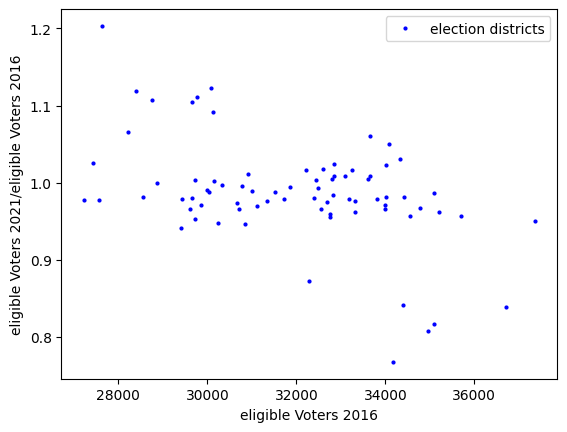

In [126]:
plt.plot(combined_district['Wahlberechtigte insgesamt_x'],combined_district['Wahlberechtigte insgesamt_y']/combined_district['Wahlberechtigte insgesamt_x'],'o',ms=2,color='blue',label='election districts') 
plt.legend(loc="best")
plt.xlabel("eligible Voters 2016")
plt.ylabel("eligible Voters 2021/eligible Voters 2016")

Looks better most are rather close 1, some a little off. 78 are clearly not enough for a good analysis and prediction. Spatial information on the districts is needed. 

In [127]:
#paarmeters> data frame, year fo x in dataset, year of y in data set
def get_percentages(dataframe,yearx,yeary):
    dataframe['spd_%_'+str(yearx)]=dataframe.SPD_x/dataframe['Gültige Stimmen_x']*100
    dataframe['spd_%_'+str(yeary)]=dataframe.SPD_y/dataframe['Gültige Stimmen_y']*100
    dataframe['cdu_%_'+str(yearx)]=dataframe.CDU_x/dataframe['Gültige Stimmen_x']*100
    dataframe['cdu_%_'+str(yeary)]=dataframe.CDU_y/dataframe['Gültige Stimmen_y']*100
    dataframe['fdp_%_'+str(yearx)]=dataframe.FDP_x/dataframe['Gültige Stimmen_x']*100
    dataframe['fdp_%_'+str(yeary)]=dataframe.FDP_y/dataframe['Gültige Stimmen_y']*100
    dataframe['afd_%_'+str(yearx)]=dataframe.AfD_x/dataframe['Gültige Stimmen_x']*100
    dataframe['afd_%_'+str(yeary)]=dataframe.AfD_y/dataframe['Gültige Stimmen_y']*100
    dataframe['greens_%_'+str(yearx)]=dataframe['GRÜNE_x']/dataframe['Gültige Stimmen_x']*100
    dataframe['greens_%_'+str(yeary)]=dataframe['GRÜNE_y']/dataframe['Gültige Stimmen_y']*100
    dataframe['lefts_%_'+str(yearx)]=dataframe['DIE LINKE_x']/dataframe['Gültige Stimmen_x']*100
    dataframe['lefts_%_'+str(yeary)]=dataframe['DIE LINKE_y']/dataframe['Gültige Stimmen_y']*100
    return dataframe

In [128]:
combined_district=get_percentages(combined_district,16, 21)
cleaned=get_percentages(cleaned,16,21)

/tmp/ipykernel_11291/3842510083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['spd_%_'+str(yearx)]=dataframe.SPD_x/dataframe['Gültige Stimmen_x']*100
/tmp/ipykernel_11291/3842510083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['spd_%_'+str(yeary)]=dataframe.SPD_y/dataframe['Gültige Stimmen_y']*100
/tmp/ipykernel_11291/3842510083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [153]:
print(combined_district.columns)
cleaned_dis=combined_district.loc[combined_district['spd_%_21'].isnull()==False]
print(cleaned_dis.shape)

Index(['Bundestags-\nwahlkreis_x', 'Wahlberechtigte insgesamt_x',
       'Wahlberechtigte A1_x', 'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x',
       'Wähler', 'Wähler B1', 'Ungültige Stimmen_x', 'Gültige Stimmen_x',
       'SPD_x', 'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'PIRATEN_x', 'NPD_x',
       'FDP_x', 'Tierschutzpartei_x', 'pro Deutschland', 'Die PARTEI_x', 'BIG',
       'DKP_x', 'ödp', 'PSG', 'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD_x', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther_x',
       'MENSCHLICHE WELT_x', 'MIETERPARTEI_x', 'Gesundheits-\nforschung',
       'Bundestags-\nwahlkreis_y', 'Wahlberechtigte insgesamt_y',
       'Wahlberechtigte A1_y', 'Wahlberechtigte A2_y', 'Wahlberechtigte A3_y',
       'Wählende', 'Wählende B1', 'Gültige Stimmen_y', 'Ungültige Stimmen_y',
       'SPD_y', 'CDU_y', 'GRÜNE_y', 'DIE LINKE_y', 'AfD_y', 'FDP_y',
       'Die PARTEI_y', 'Tierschutzpartei_y', 'PIRATEN_y', 'Graue Panther_y',
       'NPD_y', 'Gesundheitsforschung'

Text(0, 0.5, 'party (2021)-party 2016 [%]')

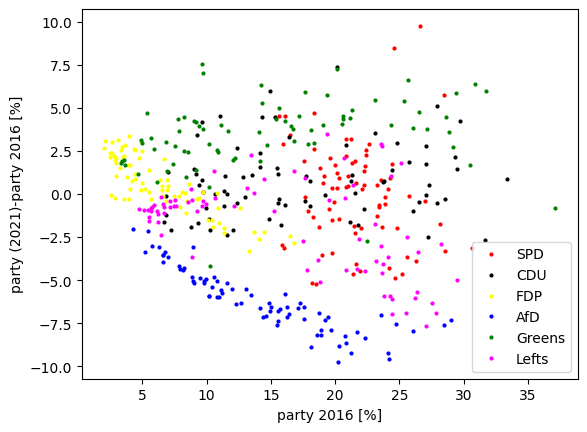

In [62]:
plt.plot(combined_district['spd_%_16'],combined_district['spd_%_21']-combined_district['spd_%_16'],'o',ms=2,color='red',label='SPD')
plt.plot(combined_district['cdu_%_16'],combined_district['cdu_%_21']-combined_district['cdu_%_16'],'o',ms=2,color='black',label='CDU') 
plt.plot(combined_district['fdp_%_16'],combined_district['fdp_%_21']-combined_district['fdp_%_16'],'o',ms=2,color='yellow',label='FDP') 
plt.plot(combined_district['afd_%_16'],combined_district['afd_%_21']-combined_district['afd_%_16'],'o',ms=2,color='blue',label='AfD')
plt.plot(combined_district['greens_%_16'],combined_district['greens_%_21']-combined_district['greens_%_16'],'o',ms=2,color='green',label='Greens') 
plt.plot(combined_district['lefts_%_16'],combined_district['lefts_%_21']-combined_district['lefts_%_16'],'o',ms=2,color='magenta',label='Lefts') 
plt.legend(loc="best")
plt.xlabel("party 2016 [%]")
plt.ylabel("party (2021)-party 2016 [%]")

Looking better now, at least some parties have a clear principle, SPD not.   Before it looked, see below

Text(0, 0.5, 'party (2021)-party 2016 [%]')

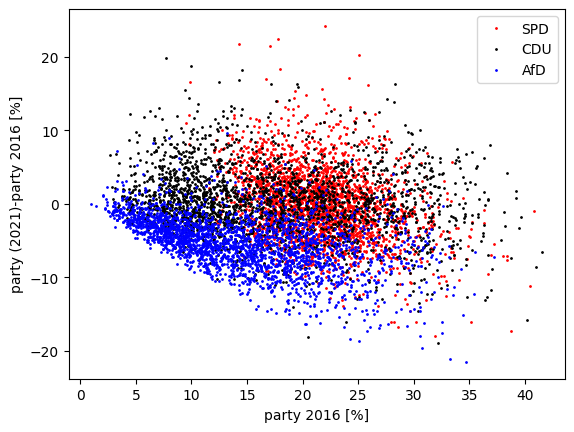

In [63]:
plt.plot(cleaned['spd_%_16'],cleaned['spd_%_21']-cleaned['spd_%_16'],'o',ms=1,color='red',label='SPD')
plt.plot(cleaned['cdu_%_16'],cleaned['cdu_%_21']-cleaned['cdu_%_16'],'o',ms=1,color='black',label='CDU') 
#plt.plot(combined_district['fdp_%_16'],combined_district['fdp_%_21']-combined_district['fdp_%_16'],'o',ms=2,color='yellow',label='FDP') 
plt.plot(cleaned['afd_%_16'],cleaned['afd_%_21']-cleaned['afd_%_16'],'o',ms=1,color='blue',label='AfD')
#plt.plot(combined_district['greens_%_16'],combined_district['greens_%_21']-combined_district['greens_%_16'],'o',ms=2,color='green',label='Greens') 
#plt.plot(combined_district['lefts_%_16'],combined_district['lefts_%_21']-combined_district['lefts_%_16'],'o',ms=2,color='magenta',label='Lefts') 
plt.legend(loc="best")
plt.xlabel("party 2016 [%]")
plt.ylabel("party (2021)-party 2016 [%]")

Especially for the AfD which has a really tight election district relation, the relation is less tight on the district level. 

Now I combined the state election 2016 and the federal election in 2017 because they have more similar election district numbers. 

In [64]:
combined1617=elec16_vote2.merge(bw17_vote2,how='inner',left_on='Adresse',right_on='Adresse')
print(combined1617.shape)
print(elec16_vote2.shape)
print(bw17_vote2.shape)

(2431, 96)
(2432, 43)
(2439, 54)


In [65]:
nulls1617=combined1617.Bezirksnummer_y.isnull()
print(sum(nulls1617))

0


In [66]:
print(combined1617.columns)

Index(['Adresse', 'Stimmart_x', 'Bezirksnummer_x', 'Bezirksname_x',
       'Wahlbezirk_x', 'Wahlbezirksart_x', 'Abgeordneten-\nhauswahlkreis_x',
       'Bundestags-\nwahlkreis_x', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt_x', 'Wahlberechtigte A1_x',
       'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x', 'Wähler_x',
       'Wähler B1_x', 'Ungültige Stimmen_x', 'Gültige Stimmen_x', 'SPD_x',
       'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'PIRATEN_x', 'NPD_x', 'FDP_x',
       'Tierschutzpartei', 'pro Deutschland', 'Die PARTEI_x', 'BIG', 'DKP_x',
       'ödp', 'PSG', 'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD_x',
       'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther', 'MENSCHLICHE WELT_x',
       'MIETERPARTEI_x', 'Gesundheits-\nforschung_x', 'Stimmart_y',
       'Bezirksnummer_y', 'Bezirksname_y', 'Wahlbezirk_y', 'Wahlbezirksart_y',
       'Abgeordneten-\nhauswahlkreis_y', 'Bundestags-\nwahlkreis_y', 'OstWest',
       'Wahlberechtigte insgesamt_y', 'Wahlberechtigte A1_y',

Now getting the percentages for the machine learning. 

In [67]:
combined1617=get_percentages(combined1617,16,17)

In [83]:
#testing for the function below 
print(combined1617.columns)
year1=16
year2=17
name="cdu"
string=name+"_%_"+str(year2)
print(string)
print(combined1617.loc[:,'cdu_%_17'])
target=combined1617.loc[:,string]-combined1617.loc[:,name+"_%_"+str(year1)]
names=['spd_%_','cdu_%_','fdp_%_','afd_%_','greens_%_','lefts_%_']
for i in range(len(names)):
    names[i]+=str(year1)
print(names)    
target2=combined1617.loc[:,names]
print(target2)

Index(['Adresse', 'Stimmart_x', 'Bezirksnummer_x', 'Bezirksname_x',
       'Wahlbezirk_x', 'Wahlbezirksart_x', 'Abgeordneten-\nhauswahlkreis_x',
       'Bundestags-\nwahlkreis_x', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt_x',
       ...
       'cdu_%_16', 'cdu_%_17', 'fdp_%_16', 'fdp_%_17', 'afd_%_16', 'afd_%_17',
       'greens_%_16', 'greens_%_17', 'lefts_%_16', 'lefts_%_17'],
      dtype='object', length=108)
cdu_%_17
0       27.918331
1       26.435331
2       27.374302
3       23.335298
4       23.667482
          ...    
2426    26.195426
2427    30.964467
2428    30.309278
2429    35.994398
2430    29.518072
Name: cdu_%_17, Length: 2431, dtype: float64
['spd_%_16', 'cdu_%_16', 'fdp_%_16', 'afd_%_16', 'greens_%_16', 'lefts_%_16']
       spd_%_16   cdu_%_16   fdp_%_16   afd_%_16  greens_%_16  lefts_%_16
0     20.257453  21.002710  11.788618   5.826558    20.731707   13.888889
1     17.335611  17.933390  14.773698   8.283518    21.349274   16.225448
2     18.022181  18.7

In [145]:
def get_scatter2(dataframe,name,year1,year2):
    print(f"party "+name)
    #select target
    target=dataframe.loc[:,name+"_%_"+str(year2)]-dataframe.loc[:,name+"_%_"+str(year1)]
    #select features
    names=['spd_%_','cdu_%_','fdp_%_','afd_%_','greens_%_','lefts_%_']
    for i in range(len(names)):
        names[i]+=str(year1)
    features=dataframe.loc[:,names]
    feature_train,feature_test,target_train, target_test= train_test_split(features,target,train_size=0.50, shuffle=True, random_state=1)
    print(feature_train.isnull().sum())    
    print(feature_test.isnull().sum()) 
    print(target_train.isnull().sum())    
    print(target_test.isnull().sum())     
    reg2c=LinearRegression().fit(feature_train, target_train)
    predli1te2c=reg2c.predict(feature_test)
    predli1tr2c=reg2c.predict(feature_train)
    reg2cx=XGBRegressor(subsample=1).fit(feature_train, target_train)#train gets worse but also test with subsample<1
    predli1te2cx=reg2cx.predict(feature_test)
    predli1tr2cx=reg2cx.predict(feature_train)
    res=np.zeros((6))
    res[0]=np.std(target_train)
    res[1]=np.std(target_test)
    res[2]=np.std(predli1tr2c-target_train)
    res[3]=np.std(predli1te2c-target_test)
    res[4]=np.std(predli1tr2cx-target_train)
    res[5]=np.std(predli1te2cx-target_test)
    print(f"standard deviation of data (train) {round(res[0],4)} %")
    print(f"standard deviation of data (test) {round(res[1],4)} %")
    print(f"standard deviation of train-data (train) {round(res[2],4)} %")
    print(f"standard deviation of prediction-data (test) {round(res[3],4)} %")
    print(f"standard deviation of train-data (train) XGB {round(res[4],4)} %")
    print(f"standard deviation of prediction-data (test) XGB {round(res[5],4)} %") 
    return res

In [118]:
get_scatter2(combined1617,'spd',16,17)

party spd
standard deviation of data (train) 2.6142 %
standard deviation of data (test) 2.7378 %
standard deviation of train-data (train) 2.0877 %
standard deviation of prediction-data (test) 2.0549 %
standard deviation of train-data (train) XGB 0.3019 %
standard deviation of prediction-data (test) XGB 2.122 %


array([2.61419095, 2.73777123, 2.08765345, 2.05492357, 0.30187231,
       2.12203029])

In [103]:
get_scatter2(combined1617,'cdu',16,17)

party cdu
standard deviation of data (train) 2.8415 %
standard deviation of data (test) 2.7992 %
standard deviation of train-data (train) 2.4697 %
standard deviation of prediction-data (test) 2.3831 %
standard deviation of train-data (train) XGB 0.3397 %
standard deviation of prediction-data (test) XGB 2.4502 %


In [104]:
get_scatter2(combined1617,'fdp',16,17)

party fdp
standard deviation of data (train) 1.5629 %
standard deviation of data (test) 1.5772 %
standard deviation of train-data (train) 1.4611 %
standard deviation of prediction-data (test) 1.4356 %
standard deviation of train-data (train) XGB 0.234 %
standard deviation of prediction-data (test) XGB 1.538 %


In [105]:
get_scatter2(combined1617,'afd',16,17)

party afd
standard deviation of data (train) 1.9022 %
standard deviation of data (test) 1.8648 %
standard deviation of train-data (train) 1.6472 %
standard deviation of prediction-data (test) 1.6821 %
standard deviation of train-data (train) XGB 0.2537 %
standard deviation of prediction-data (test) XGB 1.8393 %


In [92]:
get_scatter2(combined1617,'greens',16,17)

party greens
standard deviation of data (train) 2.6707 %
standard deviation of data (test) 3.0297 %
standard deviation of train-data (train) 1.6791 %
standard deviation of prediction-data (test) 1.7494 %
standard deviation of train-data (train) XGB 0.212 %
standard deviation of prediction-data (test) XGB 1.9501 %


In [93]:
get_scatter2(combined1617,'lefts',16,17)

party lefts
standard deviation of data (train) 2.5521 %
standard deviation of data (test) 2.636 %
standard deviation of train-data (train) 2.088 %
standard deviation of prediction-data (test) 2.0999 %
standard deviation of train-data (train) XGB 0.2959 %
standard deviation of prediction-data (test) XGB 2.1894 %


Text(0, 0.5, 'party (2027)-party 2016 [%]')

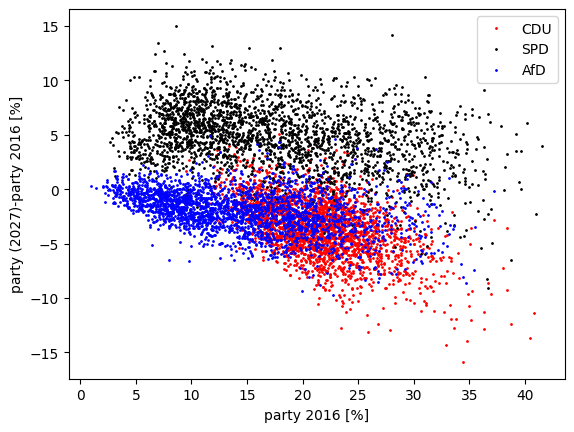

In [95]:
plt.plot(combined1617['spd_%_16'],combined1617['spd_%_17']-combined1617['spd_%_16'],'o',ms=1,color='red',label='CDU')
plt.plot(combined1617['cdu_%_16'],combined1617['cdu_%_17']-combined1617['cdu_%_16'],'o',ms=1,color='black',label='SPD')
plt.plot(combined1617['afd_%_16'],combined1617['afd_%_17']-combined1617['afd_%_16'],'o',ms=1,color='blue',label='AfD')
plt.legend(loc="best")
plt.xlabel("party 2016 [%]")
plt.ylabel("party (2027)-party 2016 [%]")

In [106]:
elec_district17=bw17_vote2.groupby([bw17_vote2['Bezirksnummer'],bw17_vote2['Abgeordneten-\nhauswahlkreis']]).sum()

/tmp/ipykernel_11291/2617108343.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_district17=bw17_vote2.groupby([bw17_vote2['Bezirksnummer'],bw17_vote2['Abgeordneten-\nhauswahlkreis']]).sum()


In [108]:
print(elec_district17.shape)

(78, 47)


In [109]:
combined_district1617=elec_district16.merge(elec_district17,how='left',left_index=True,right_index=True)

In [113]:
combined_district1617=get_percentages(combined_district1617,16, 17)
print(combined_district1617.columns)

Index(['Bundestags-\nwahlkreis_x', 'Wahlberechtigte insgesamt_x',
       'Wahlberechtigte A1_x', 'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x',
       'Wähler_x', 'Wähler B1_x', 'Ungültige Stimmen_x', 'Gültige Stimmen_x',
       'SPD_x', 'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'PIRATEN_x', 'NPD_x',
       'FDP_x', 'Tierschutzpartei', 'pro Deutschland', 'Die PARTEI_x', 'BIG',
       'DKP_x', 'ödp', 'PSG', 'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD_x', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther',
       'MENSCHLICHE WELT_x', 'MIETERPARTEI_x', 'Gesundheits-\nforschung_x',
       'Stimmart', 'Bundestags-\nwahlkreis_y', 'Wahlberechtigte insgesamt_y',
       'Wahlberechtigte A1_y', 'Wahlberechtigte A2_y', 'Wahlberechtigte A3_y',
       'Wähler_y', 'Wähler B1_y', 'Ungültige Stimmen_y', 'Gültige Stimmen_y',
       'CDU_y', 'SPD_y', 'DIE LINKE_y', 'GRÜNE_y', 'AfD_y', 'PIRATEN_y',
       'FDP_y', 'Die PARTEI_y', 'FREIE WÄHLER', 'ÖDP', 'BüSo_y', 'MLPD', 'SGP',
       'B*', 'BGE

Text(0, 0.5, 'party (2017)-party 2016 [%]')

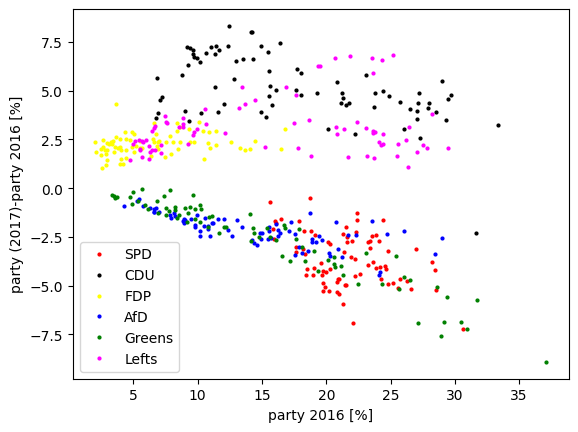

In [114]:
plt.plot(combined_district1617['spd_%_16'],combined_district1617['spd_%_17']-combined_district1617['spd_%_16'],'o',ms=2,color='red',label='SPD')
plt.plot(combined_district1617['cdu_%_16'],combined_district1617['cdu_%_17']-combined_district1617['cdu_%_16'],'o',ms=2,color='black',label='CDU') 
plt.plot(combined_district1617['fdp_%_16'],combined_district1617['fdp_%_17']-combined_district1617['fdp_%_16'],'o',ms=2,color='yellow',label='FDP') 
plt.plot(combined_district1617['afd_%_16'],combined_district1617['afd_%_17']-combined_district1617['afd_%_16'],'o',ms=2,color='blue',label='AfD')
plt.plot(combined_district1617['greens_%_16'],combined_district1617['greens_%_17']-combined_district1617['greens_%_16'],'o',ms=2,color='green',label='Greens') 
plt.plot(combined_district1617['lefts_%_16'],combined_district1617['lefts_%_17']-combined_district1617['lefts_%_16'],'o',ms=2,color='magenta',label='Lefts') 
plt.legend(loc="best")
plt.xlabel("party 2016 [%]")
plt.ylabel("party (2017)-party 2016 [%]")

In [115]:
get_scatter2(combined_district1617,'spd',16,17)

party spd
standard deviation of data (train) 1.3713 %
standard deviation of data (test) 1.3367 %
standard deviation of train-data (train) 0.7847 %
standard deviation of prediction-data (test) 0.8064 %
standard deviation of train-data (train) XGB 0.0007 %
standard deviation of prediction-data (test) XGB 1.0776 %


In [121]:
parties=['spd','cdu','fdp','afd','greens','lefts']
res2=np.zeros((2,6))
for i in range(len(parties)):
    res=get_scatter2(combined_district1617,parties[i],16,17)
    res2[0,i]=(res[2]+res[3])/(res[0]+res[1])
    resb=get_scatter2(combined1617,parties[i],16,17)
    res2[1,i]=(resb[2]+resb[3])/(resb[0]+resb[1])
print(res2)    

party spd
standard deviation of data (train) 1.3713 %
standard deviation of data (test) 1.3367 %
standard deviation of train-data (train) 0.7847 %
standard deviation of prediction-data (test) 0.8064 %
standard deviation of train-data (train) XGB 0.0007 %
standard deviation of prediction-data (test) XGB 1.0776 %
party spd
standard deviation of data (train) 2.6142 %
standard deviation of data (test) 2.7378 %
standard deviation of train-data (train) 2.0877 %
standard deviation of prediction-data (test) 2.0549 %
standard deviation of train-data (train) XGB 0.3019 %
standard deviation of prediction-data (test) XGB 2.122 %
party cdu
standard deviation of data (train) 1.7855 %
standard deviation of data (test) 1.4808 %
standard deviation of train-data (train) 1.0293 %
standard deviation of prediction-data (test) 1.0179 %
standard deviation of train-data (train) XGB 0.0008 %
standard deviation of prediction-data (test) XGB 1.5297 %
party cdu
standard deviation of data (train) 2.8415 %
standard

For election district improvement is 8 to 23 % while it is 29 to 76% for the full districts. 

In [ ]:
Looks similar to before. Quantify. 

In [155]:
res3=np.zeros((2,6))
for i in range(len(parties)):
    res=get_scatter2(cleaned_dis,parties[i],16,21)
    res3[0,i]=(res[2]+res[3])/(res[0]+res[1])
    resb=get_scatter2(cleaned,parties[i],16,21)
    res3[1,i]=(resb[2]+resb[3])/(resb[0]+resb[1])
print(res3)   

party spd
spd_%_16       0
cdu_%_16       0
fdp_%_16       0
afd_%_16       0
greens_%_16    0
lefts_%_16     0
dtype: int64
spd_%_16       0
cdu_%_16       0
fdp_%_16       0
afd_%_16       0
greens_%_16    0
lefts_%_16     0
dtype: int64
0
0
standard deviation of data (train) 3.3534 %
standard deviation of data (test) 2.4838 %
standard deviation of train-data (train) 2.3423 %
standard deviation of prediction-data (test) 1.8436 %
standard deviation of train-data (train) XGB 0.0007 %
standard deviation of prediction-data (test) XGB 1.4763 %
party spd
spd_%_16       0
cdu_%_16       0
fdp_%_16       0
afd_%_16       0
greens_%_16    0
lefts_%_16     0
dtype: int64
spd_%_16       0
cdu_%_16       0
fdp_%_16       0
afd_%_16       0
greens_%_16    0
lefts_%_16     0
dtype: int64
0
0
standard deviation of data (train) 4.9951 %
standard deviation of data (test) 4.8475 %
standard deviation of train-data (train) 4.2165 %
standard deviation of prediction-data (test) 4.0975 %
standard deviation

Here on smallest units the improvment is 6 to 27% while it is 13 to 63% for the full districts. Thus, it is rather similar and not better as expected when the districts would be more similar. 

Thus I really need to understand teh districts and how they changed in size and origin.

Also getting better wqith XGBoost with less big data sources would also be good. 